# Assignment 2 - Keras

In [1]:
# importing relevant libraries
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, f1_score
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Exploratory data analysis

Before we do any kind of prediction let's perform some analysis on our data. We first read the dataset from a csv file which is created from the provided excel file. We examine the head of the data

In [2]:
# dataset reading
ROOT_DIR = "/Users/nikunjlad"   # defining the root dir
data = pd.read_csv(os.path.join(ROOT_DIR, "data") + "/loan.csv")   # reading the csv file using pandas
data.head()   # observing the head of the dataframe

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,M,50.750000,0.585,owner,given,unemploye,unemploye,0,0,f,given,145,0,reject
1,M,19.670000,10.000,rent,not_given,labourer,governmen,0,0,t,given,140,0,reject
2,F,52.830002,15.000,owner,given,creative_,private_s,5,14,f,given,0,2200,accept
3,M,22.670000,2.540,rent,not_given,creative_,governmen,2,0,f,given,0,0,accept
4,M,29.250000,13.000,owner,given,driver,governmen,0,0,f,given,228,0,reject


From the above loan data, we can observe that, a loan decision can be affected by various parameters like,

1. how old a person is,
2. his occupation
3. what's his job status
4. amount of money 
5. residential status whether he is owner or a tenant

In [3]:
data.describe()

,Age,Time_at_address,Time_employed,Time_bank,Home_Expn,Balance
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,31.510163,4.650758,1.871795,2.279720,176.727273,898.382284
std,11.843595,4.804037,3.254023,3.966105,142.590659,3814.565340
min,15.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.670000,1.000000,0.000000,0.000000,80.000000,0.000000
50%,28.500000,2.750000,1.000000,0.000000,160.000000,10.000000
75%,38.250000,7.000000,2.000000,3.000000,272.000000,484.000000
max,76.750000,25.209999,20.000000,23.000000,760.000000,51100.000000


In [4]:
data.shape  # data has 429 rows and 14 columns which are very less for neural network modelling.

(429, 14)

In [5]:
data.isna().sum()   # luckily, the dataset does not contain any kind of Null values

Sex                0
Age                0
Time_at_address    0
Res_status         0
Telephone          0
Occupation         0
Job_status         0
Time_employed      0
Time_bank          0
Liab_ref           0
Acc_ref            0
Home_Expn          0
Balance            0
Decision           0
dtype: int64

How many unique values in a columns exist in the dataset. This will help us in figuring out if we need to encode the column values for predictions. We query the categorical columns to see how many unique values exist

In [6]:
# finding unique values
def get_unique_values(cols):
    
    # create a dictionary to hold unique values in the columns and the number of unique values
    unique_dict = dict()   
    for col in cols:
        obs = list()
        obs.append(list(data[col].unique()))  # list of unique values
        obs.append(len(obs[0]))  # num of unique values in the column
        unique_dict[col] = obs
        
    return unique_dict

In [7]:
cat_cols = ["Sex", "Res_status", "Telephone", "Liab_ref", "Acc_ref", "Occupation", "Job_status", "Decision"]   
unique_cols = get_unique_values(cat_cols)
unique_cols

{'Sex': [['M', 'F'], 2],
 'Res_status': [['owner', 'rent'], 2],
 'Telephone': [['given', 'not_given'], 2],
 'Liab_ref': [['f', 't'], 2],
 'Acc_ref': [['given', 'oth_inst_'], 2],
 'Occupation': [['unemploye',
   'labourer',
   'creative_',
   'driver',
   'professio',
   'manager',
   'guard_etc',
   'executive',
   'office_st',
   'productio',
   'semi_pro',
   'sales'],
  12],
 'Job_status': [['unemploye',
   'governmen',
   'private_s',
   'self_empl',
   'retired',
   'student',
   'military'],
  7],
 'Decision': [['reject', 'accept'], 2]}

From the above results, we see that except Occupation and Job status all other columns have almost 2 unique values. Encoding 2 values from categorical to numerical format is essentially encoding it into 0 and 1. However, encoding, other features will be difficult since one hot encoding creates new columns each corresponding to a unique value

In [8]:
query_cols = ["Sex", "Res_status", "Telephone", "Liab_ref", "Acc_ref", "Decision"]   
unique_cols_dict = get_unique_values(query_cols)
unique_cols_dict

{'Sex': [['M', 'F'], 2],
 'Res_status': [['owner', 'rent'], 2],
 'Telephone': [['given', 'not_given'], 2],
 'Liab_ref': [['f', 't'], 2],
 'Acc_ref': [['given', 'oth_inst_'], 2],
 'Decision': [['reject', 'accept'], 2]}

In [9]:
def label_features(feature_list):
    # function to encode the categorical columns
    feature_labels = list()   # labels list
    feature_mappings = list()  # corresponding mappings between the labels and categorical values
    for feature in feature_list:
        gle = LabelEncoder()
        feature_labels.append(gle.fit_transform(data[feature]))
        feature_mappings.append({index: label for index, label in enumerate(gle.classes_)})
    return feature_labels, feature_mappings

In [10]:
labels, mappings = label_features(query_cols)
mappings

[{0: 'F', 1: 'M'},
 {0: 'owner', 1: 'rent'},
 {0: 'given', 1: 'not_given'},
 {0: 'f', 1: 't'},
 {0: 'given', 1: 'oth_inst_'},
 {0: 'accept', 1: 'reject'}]

In [11]:
# replace the data column values with respective encoded labels
for ind, col in enumerate(query_cols):
    data[col] = labels[ind]

In [12]:
data.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,1,50.750000,0.585,0,0,unemploye,unemploye,0,0,0,0,145,0,1
1,1,19.670000,10.000,1,1,labourer,governmen,0,0,1,0,140,0,1
2,0,52.830002,15.000,0,0,creative_,private_s,5,14,0,0,0,2200,0
3,1,22.670000,2.540,1,1,creative_,governmen,2,0,0,0,0,0,0
4,1,29.250000,13.000,0,0,driver,governmen,0,0,0,0,228,0,1


From the above table, we see that the binary valued categorical variables are encoded to 0 and 1. However, those columns having more than 2 unique values can be one hot encoded. This will essentially lead to a new column generation as we mentioned earlier. However, for those columns having 3 or more unique columns, one hot encoding will lead to **CURSE OF DIMENSIONALITY**. To avoid this we do feature hashing. Feature hasher uniquely encodes categorical columns with more than 3-4 unique values into k feature columns. Here, we have encoded Occupation column values from 12 to 5 while Job status values from 7 to 3. Instead of creating 19 new columns we just create 9 new columns. Feature hasher uses a signed 32 bit version of the **Murmurhash3 Hash function**

In [13]:
def feature_hasher(feature, num):
    
    # num is number of feature maps to generate with the hasher
    fh = FeatureHasher(n_features=num, input_type='string')
    hashed_features = fh.fit_transform(data[feature])
    hashed_features = hashed_features.toarray()
    col_names = [feature + str(n) for n in range(num)]
    df = pd.concat([data, pd.DataFrame(hashed_features, columns=col_names)], axis=1)
    return df

data = feature_hasher("Occupation", 5)
data = feature_hasher("Job_status", 3)
data = data.drop(["Occupation", "Job_status"], axis=1)
data.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision,Occupation0,Occupation1,Occupation2,Occupation3,Occupation4,Job_status0,Job_status1,Job_status2
0,1,50.750000,0.585,0,0,0,0,0,0,145,0,1,0.0,0.0,2.0,1.0,2.0,-2.0,6.0,1.0
1,1,19.670000,10.000,1,1,0,0,1,0,140,0,1,3.0,-1.0,2.0,1.0,1.0,-2.0,5.0,-2.0
2,0,52.830002,15.000,0,0,5,14,0,0,0,2200,0,2.0,-1.0,-1.0,0.0,1.0,-3.0,2.0,0.0
3,1,22.670000,2.540,1,1,2,0,0,0,0,0,0,2.0,-1.0,-1.0,0.0,1.0,-2.0,5.0,-2.0
4,1,29.250000,13.000,0,0,0,0,0,0,228,0,1,2.0,-1.0,0.0,-1.0,2.0,-2.0,5.0,-2.0


We decide to have a histogram plot to observe the nature of the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14e495630>,
      dtype=object)

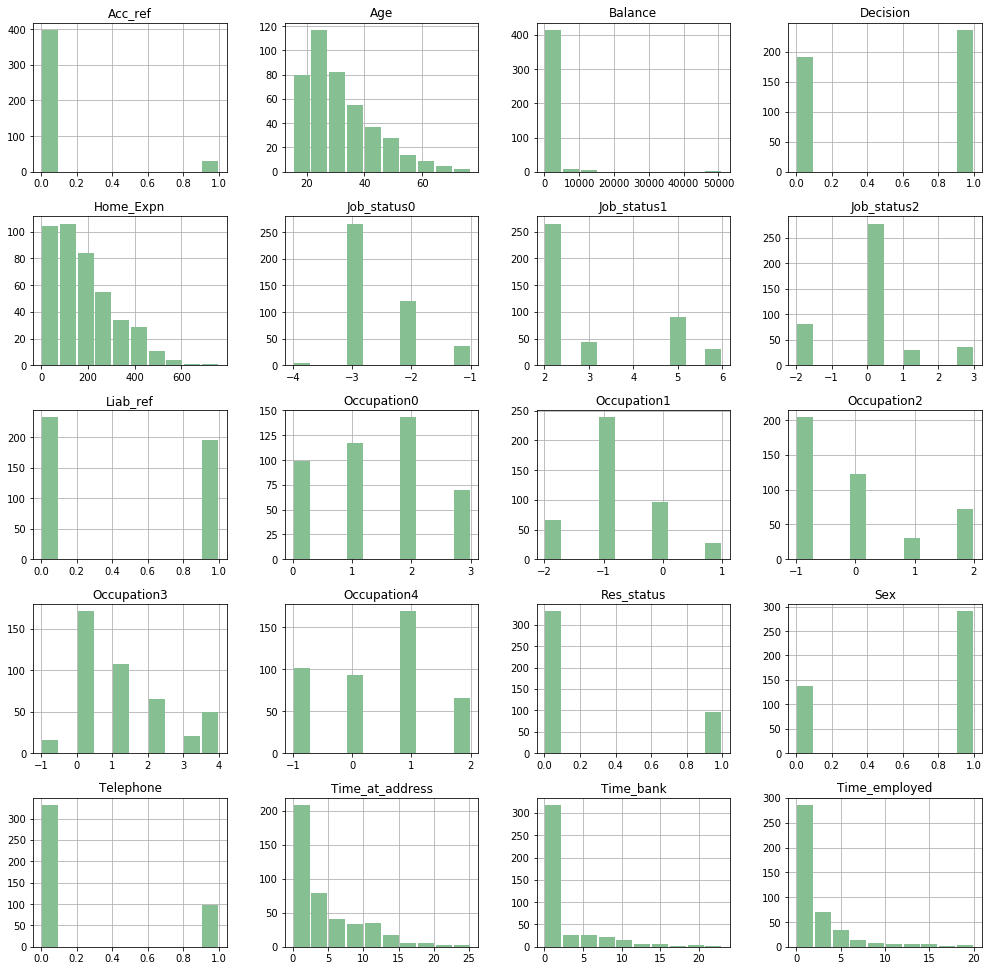

In [14]:
data.hist(figsize=(17,17), color='#86bf91', zorder=2, rwidth=0.9)

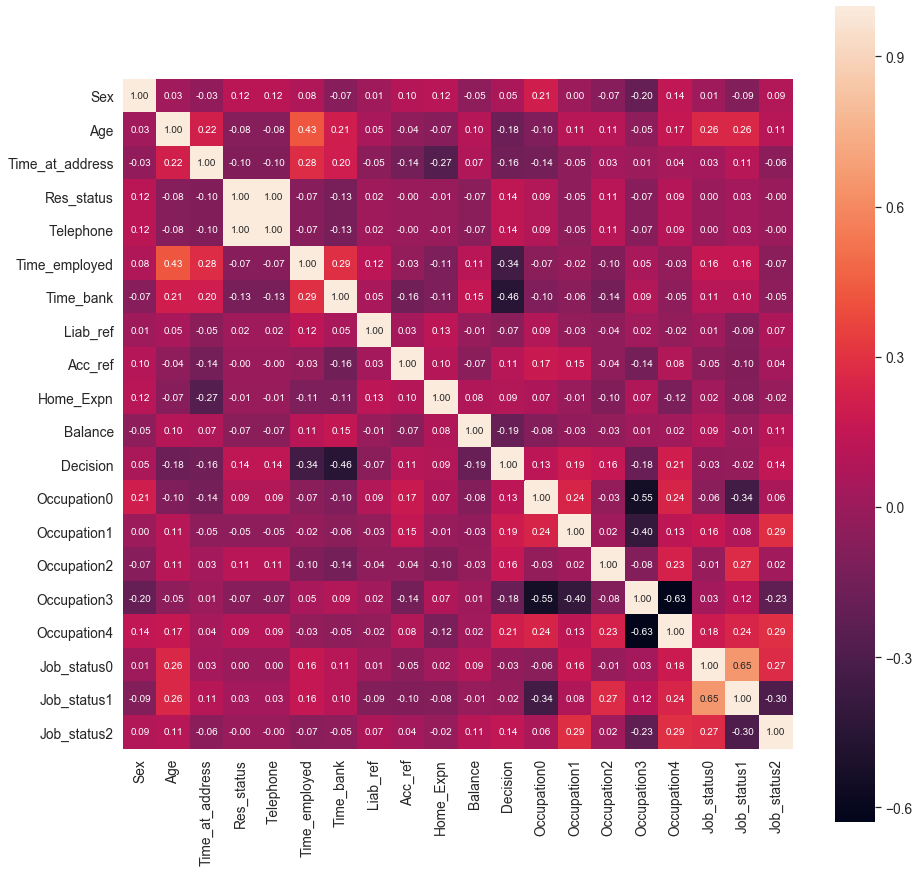

In [15]:
corr = data.corr()
cols = corr.index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The correlation matrix above gives information about the strength of the relationship between variables. We only look at the bottom half of the matrix, below the diagonal since the upper half of the triangle consists of the same values. The positive values denote positive covariance i.e if one variable increases another increases too, while negative value indicates negative covariance, i.e if one variable decreases another increases and vice-versa. How strong is this variation is given by the magnitude of this values. That is essentially correlation. It gives strength of covariance in a particular direction.

From the above correlation matrix, we need to find variables which have impact on our target variable of Decision as to whether a loan will be rejected or approved. The variables which show strong correlation are:

1. Time_bank
2. Time_employed
3. All occupations (only 1,2,3 4)
4. Balance
5. Age
6. Time_at_address
7. Job_status2

Hence we select only these columns for predictions since they have higher probability for decision making.


In [16]:
df = data[["Age","Time_at_address","Time_employed","Time_bank","Balance","Occupation1","Occupation2","Occupation3",
            "Occupation4"]]
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation2,Occupation3,Occupation4
0,50.750000,0.585,0,0,0,0.0,2.0,1.0,2.0
1,19.670000,10.000,0,0,0,-1.0,2.0,1.0,1.0
2,52.830002,15.000,5,14,2200,-1.0,-1.0,0.0,1.0
3,22.670000,2.540,2,0,0,-1.0,-1.0,0.0,1.0
4,29.250000,13.000,0,0,0,-1.0,0.0,-1.0,2.0


In [17]:
# data needs to be scaled into 0-1 range
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns)
df["Decision"] = data["Decision"]
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation2,Occupation3,Occupation4,Decision
0,0.577785,0.023205,0.00,0.000000,0.000000,0.666667,1.000000,0.4,1.000000,1
1,0.073076,0.396668,0.00,0.000000,0.000000,0.333333,1.000000,0.4,0.666667,1
2,0.611562,0.595002,0.25,0.608696,0.043053,0.333333,0.000000,0.2,0.666667,0
3,0.121793,0.100754,0.10,0.000000,0.000000,0.333333,0.000000,0.2,0.666667,0
4,0.228646,0.515668,0.00,0.000000,0.000000,0.333333,0.333333,0.0,1.000000,1


In [18]:
data = df.to_numpy()
np.random.shuffle(data)

In [19]:
X = data[:,:-1]
y = data[:,-1:]
print(X.shape, y.shape)

(429, 9) (429, 1)


In [20]:
# we have 3% testing data and 10% validation data for our modelling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.03, random_state = 333)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.07, random_state = 333)

In [21]:
X_train.shape  # 374 samples in training

(386, 9)

In [22]:
X_valid.shape   # 42 samples in validation

(30, 9)

In [23]:
X_test.shape

(13, 9)

## Architecting Neural Networks

<img src="net.png">

In [24]:
# define network architecture
model = Sequential()
model.add(Dense(16, input_dim=9, activation="relu", kernel_initializer='random_uniform'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', kernel_initializer='random_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu', kernel_initializer='random_uniform'))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

# define optimizer, loss function for learning and metrics for evaluation
sgd = optimizers.SGD(lr=0.15, decay=1e-6, momentum=0.4, nesterov=True)
# adam = optimizers.Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy','mse'])

# fit your model
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_valid, y_valid))

# # get the accuracy of the model
scores = model.evaluate(X_valid, y_valid)
print('Accuracy: %.2f' %(scores[1] * 100))

Train on 386 samples, validate on 30 samples
Epoch 1/250
386/386 [==============================] - 0s 1ms/step - loss: 0.6328 - accuracy: 0.6244 - mse: 0.2201 - val_loss: 0.6910 - val_accuracy: 0.5333 - val_mse: 0.2489
Epoch 2/250
386/386 [==============================] - 0s 63us/step - loss: 0.5809 - accuracy: 0.7202 - mse: 0.1964 - val_loss: 0.6853 - val_accuracy: 0.5333 - val_mse: 0.2460
Epoch 3/250
386/386 [==============================] - 0s 63us/step - loss: 0.6843 - accuracy: 0.6477 - mse: 0.2381 - val_loss: 0.6844 - val_accuracy: 0.5333 - val_mse: 0.2456
Epoch 4/250
386/386 [==============================] - 0s 64us/step - loss: 0.5759 - accuracy: 0.7098 - mse: 0.1942 - val_loss: 0.7215 - val_accuracy: 0.5333 - val_mse: 0.2633
Epoch 5/250
386/386 [==============================] - 0s 83us/step - loss: 0.6057 - accuracy: 0.6373 - mse: 0.2113 - val_loss: 0.7073 - val_accuracy: 0.5333 - val_mse: 0.2568
Epoch 6/250
386/386 [==============================] - 0s 104us/step - loss:

386/386 [==============================] - 0s 56us/step - loss: 0.5154 - accuracy: 0.7591 - mse: 0.1693 - val_loss: 0.4532 - val_accuracy: 0.8667 - val_mse: 0.1358
Epoch 48/250
386/386 [==============================] - 0s 59us/step - loss: 0.5040 - accuracy: 0.7642 - mse: 0.1638 - val_loss: 0.4824 - val_accuracy: 0.7667 - val_mse: 0.1573
Epoch 49/250
386/386 [==============================] - 0s 54us/step - loss: 0.5078 - accuracy: 0.7539 - mse: 0.1668 - val_loss: 0.4560 - val_accuracy: 0.8667 - val_mse: 0.1318
Epoch 50/250
386/386 [==============================] - 0s 52us/step - loss: 0.5114 - accuracy: 0.7720 - mse: 0.1663 - val_loss: 0.5089 - val_accuracy: 0.7333 - val_mse: 0.1679
Epoch 51/250
386/386 [==============================] - 0s 48us/step - loss: 0.5032 - accuracy: 0.7565 - mse: 0.1631 - val_loss: 0.4728 - val_accuracy: 0.8667 - val_mse: 0.1511
Epoch 52/250
386/386 [==============================] - 0s 47us/step - loss: 0.5035 - accuracy: 0.7642 - mse: 0.1648 - val_loss:

386/386 [==============================] - 0s 46us/step - loss: 0.4938 - accuracy: 0.7720 - mse: 0.1605 - val_loss: 0.4994 - val_accuracy: 0.8333 - val_mse: 0.1526
Epoch 140/250
386/386 [==============================] - 0s 49us/step - loss: 0.5093 - accuracy: 0.7617 - mse: 0.1667 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_mse: 0.2079
Epoch 141/250
386/386 [==============================] - 0s 49us/step - loss: 0.5432 - accuracy: 0.7539 - mse: 0.1801 - val_loss: 0.4789 - val_accuracy: 0.8333 - val_mse: 0.1494
Epoch 142/250
386/386 [==============================] - 0s 46us/step - loss: 0.4852 - accuracy: 0.7953 - mse: 0.1580 - val_loss: 0.4523 - val_accuracy: 0.8333 - val_mse: 0.1418
Epoch 143/250
386/386 [==============================] - 0s 45us/step - loss: 0.4874 - accuracy: 0.7798 - mse: 0.1570 - val_loss: 0.4507 - val_accuracy: 0.8333 - val_mse: 0.1420
Epoch 144/250
386/386 [==============================] - 0s 49us/step - loss: 0.4885 - accuracy: 0.7694 - mse: 0.1597 - val_

386/386 [==============================] - 0s 51us/step - loss: 0.4878 - accuracy: 0.7850 - mse: 0.1570 - val_loss: 0.4634 - val_accuracy: 0.8667 - val_mse: 0.1428
Epoch 232/250
386/386 [==============================] - 0s 49us/step - loss: 0.4950 - accuracy: 0.7824 - mse: 0.1589 - val_loss: 0.5197 - val_accuracy: 0.8000 - val_mse: 0.1669
Epoch 233/250
386/386 [==============================] - 0s 49us/step - loss: 0.5017 - accuracy: 0.7772 - mse: 0.1645 - val_loss: 0.4490 - val_accuracy: 0.8333 - val_mse: 0.1372
Epoch 234/250
386/386 [==============================] - 0s 49us/step - loss: 0.4858 - accuracy: 0.7902 - mse: 0.1546 - val_loss: 0.5162 - val_accuracy: 0.8000 - val_mse: 0.1658
Epoch 235/250
386/386 [==============================] - 0s 51us/step - loss: 0.5014 - accuracy: 0.7850 - mse: 0.1640 - val_loss: 0.4844 - val_accuracy: 0.8000 - val_mse: 0.1521
Epoch 236/250
386/386 [==============================] - 0s 50us/step - loss: 0.5035 - accuracy: 0.7798 - mse: 0.1640 - val_

In [25]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

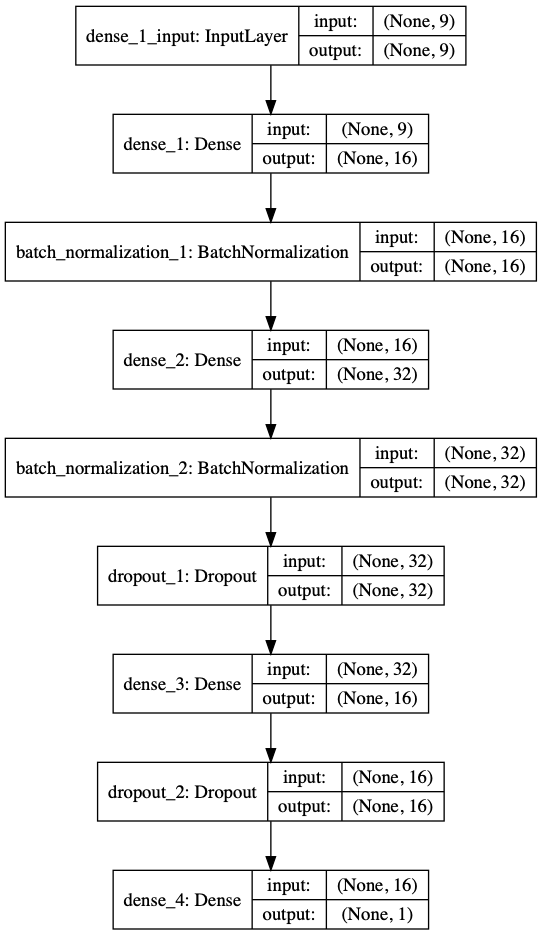

In [26]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train-Validation Loss curves

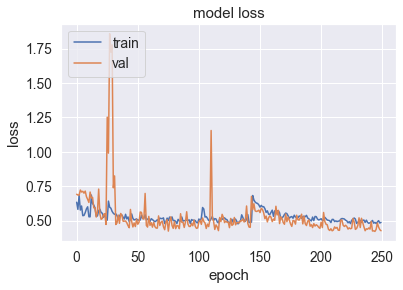

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig = plt.gcf()
fig.savefig("loss.png")
plt.show()

### Train-Validation Accuracy curves

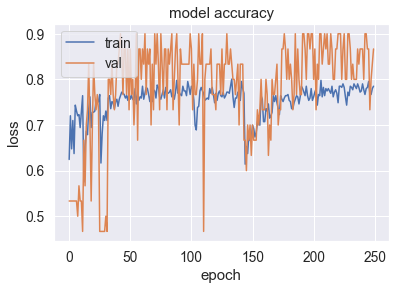

In [28]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig = plt.gcf()
fig.savefig("accuracy.png")
plt.show()

In [29]:
ypred = model.predict(x=X_test, verbose=1)

13/13 [==============================] - 0s 4ms/step


In [30]:
predicted = [1 if i >= 0.5 else 0 for i in ypred]
original = [int(i) for i in y_test]

hits = [i for i, j in zip(predicted, original) if i == j]
test_accuracy = len(hits) / len(original) * 100
print("\nTest data accuracy: " + str(test_accuracy) + "%")


Test data accuracy: 84.61538461538461%


### Confusion Matrix

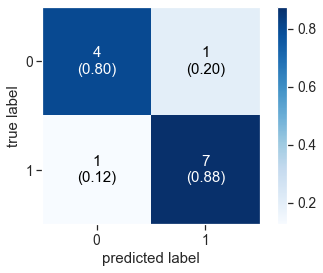

In [31]:
result = confusion_matrix(original, predicted)
_, __ = plot_confusion_matrix(conf_mat=result, show_absolute=True, show_normed=True, colorbar=True)
fig = plt.gcf()
fig.savefig("confusion.png")
plt.show()